In [2]:
# Import required libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [3]:
class GridEnvironment(gym.Env):
    metadata = {'render.modes': []}

    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10
        self.done = False
        self.timestep = 0

    def reset(self):
        self.state = np.zeros((4, 4))
        self.done = False
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1  # Initial agent position
        self.state[tuple(self.goal_pos)] = 0.5  # Goal position

        self.rocks = [(0, 3), (1, 2)]  # Rocks positions
        for rock_pos in self.rocks:
            self.state[rock_pos] = -1  # Rocks as negative rewards

        self.rewards = [(2, 1), (2, 2)]  # Rewards positions
        for reward_pos in self.rewards:
            self.state[reward_pos] = 2  # Positive rewards at reward positions

        observation = self.state.flatten()
        return observation

    def step(self, action):
        if action == 0:  # Down
            self.agent_pos[0] += 1
        elif action == 1:  # Up
            self.agent_pos[0] -= 1
        elif action == 2:  # Right
            self.agent_pos[1] += 1
        elif action == 3:  # Left
            self.agent_pos[1] -= 1

        # Comment this to demonstrate the truncation condition.
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5

        for rock_pos in self.rocks:
            self.state[rock_pos] = -1

        for reward_pos in self.rewards:
            self.state[reward_pos] = 2 

        observation = self.state.flatten()

        reward = 0
        if np.array_equal(self.agent_pos, self.goal_pos):
            reward = 15
            self.done = True
        elif tuple(self.agent_pos) in self.rocks:
            if tuple(self.agent_pos) == (0, 3):
                reward = -3  
            elif tuple(self.agent_pos) == (1, 2):
                reward = -2 
        elif tuple(self.agent_pos) in self.rewards:
            if tuple(self.agent_pos) == (2, 1):
                reward = 2
            elif tuple(self.agent_pos) == (2, 2):
                reward = 4 

        self.timestep += 1

        terminated = True if self.timestep >= self.max_timesteps else False

        agentState = self.agent_pos
        isDone = self.done
        timestepCount = self.timestep

        return observation, reward, terminated, agentState, isDone, timestepCount

    def render(self):
        plt.title('Grid World')

        # Visualize rocks as red color
        for rock_pos in self.rocks:
            plt.scatter(rock_pos[1], rock_pos[0], color='red', marker='s', s=300)

        # Visualize rewards as orange color
        for reward_pos in self.rewards:
            plt.scatter(reward_pos[1], reward_pos[0], color='orange', marker='P', s=300)

        # Visualize agent as green color
        plt.scatter(self.agent_pos[1], self.agent_pos[0], color='green', marker='o', s=300)

        # Visualize the goal as blue color
        plt.scatter(self.goal_pos[1], self.goal_pos[0], color='blue', marker='*', s=300)
        plt.imshow(self.state)
        plt.show()

In [4]:
actionsEquivalent = {0:'Down', 1:'Up', 2:'Right', 3:'Left'}
statesEquivalent = {(0,0):'S1', (0,1):'S2', (0,2):'S3', (0,3):'S4', (1,0):'S5', (1,1):'S6', (1,2):'S7', 
                    (1,3):'S8',(2,0):'S9',(2,1):'S10',(2,2):'S11', (2,3):'S12', (3,0):'S13', (3,1):'S14', 
                    (3,2):'S15', (3,3):'S16'}

In [71]:
# SARSA algorithm for OpenAI Gym environment
def SARSA(env, testing, episodes, timesteps):
    env.reset()

    learningRate = 0.15
    discountFactor = 0.95

    initial_Q = np.zeros((env.observation_space.n, env.action_space.n))
    trained_Q = np.zeros((env.observation_space.n, env.action_space.n))

    testingEpisodes = 10
    episodes = episodes + testingEpisodes if testing else episodes
    epsilon = 1
    decayFactor = (0.01/1) ** (1/episodes)
    actionVals = [0, 1, 2, 3]
    rewardVals = []
    testingRewardVals = []
    optimalVals, optimalActions = [], []
    epsilonVals = []
    closeTarget = [(3, 2), (2, 3)]

    agentStates = {(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3,
                   (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7,
                   (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, 3): 11,
                   (3, 0): 12, (3, 1): 13, (3, 2): 14, (3, 3): 15}

    def epsilon_greedy_policy(Q, state, epsilon):
        if np.random.random() < epsilon:
            return np.random.choice(actionVals)
        else:
            return np.argmax(Q[state])

    for eps in range(episodes):
        env.reset()
        currentState, rewardsTotal, timestep = 0, 0, 0
        currAction = epsilon_greedy_policy(trained_Q, currentState, epsilon)

        while timestep != timesteps:
            _, reward, _, agentState, done, _ = env.step(currAction)
            nextState = agentStates[tuple(agentState)]

            # when goal reached assign higher reward
            reward = reward + 110 if reward == 15 else reward
            # # When its about to reach the goal assign higher reward
            for agent in closeTarget:
                if (agent == agentState).all():
                    reward += 6 

            nextAction = epsilon_greedy_policy(trained_Q, nextState, epsilon)

            trained_Q[currentState][currAction] = trained_Q[currentState][currAction] + learningRate * \
                (reward + discountFactor * trained_Q[nextState]
                 [nextAction] - trained_Q[currentState][currAction])

            timestep += 1
            rewardsTotal += reward

            optimalActions.append(currAction) if eps == episodes-1 else None
            optimalVals.append(currentState) if eps == episodes-1 else None

            currentState = nextState
            currAction = nextAction

            if done:
                break

        epsilon = epsilon * decayFactor if epsilon > 0.01 else 0.01
        rewardVals.append(rewardsTotal)
        epsilonVals.append(epsilon)

        optimalVals.append(nextState) if eps == episodes-1 else None


        testingRewardVals.append(reward) if testing and eps > (
            episodes - testingEpisodes-1) else None
    

    return initial_Q, trained_Q, testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals, optimalVals, optimalActions

### Optimal Path

Optimal Path: S1 --> S5 --> S9 --> S10 --> S11 --> S15 --> S16


Environment Initial State


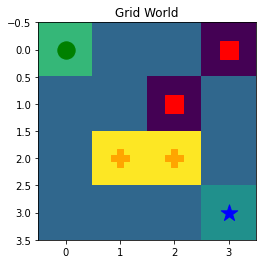


Current State: S5 = (1, 0) | Action = Down | Reward = 0 | Done = False


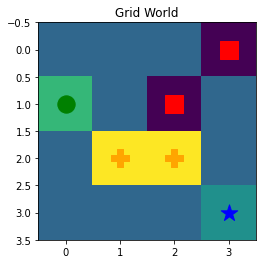


Current State: S9 = (2, 0) | Action = Down | Reward = 0 | Done = False


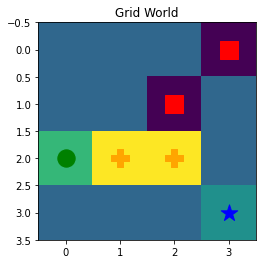


Current State: S10 = (2, 1) | Action = Right | Reward = 2 | Done = False


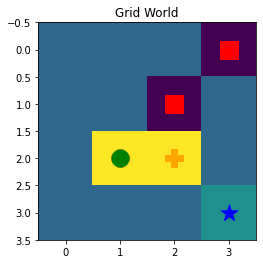


Current State: S11 = (2, 2) | Action = Right | Reward = 4 | Done = False


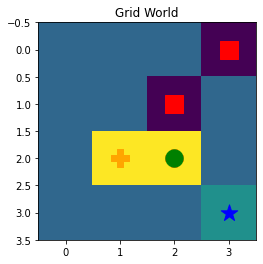


Current State: S15 = (3, 2) | Action = Down | Reward = 0 | Done = False


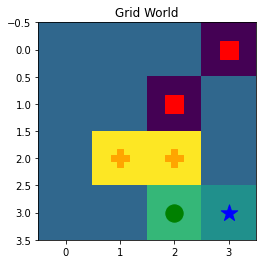

Environment Goal State

Current State: S16 = (3, 3) | Action = Right | Reward = 15 | Done = True


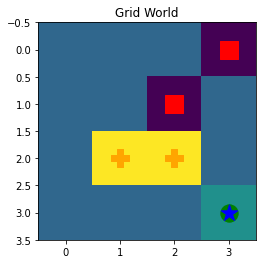

In [89]:
currentStateEquivalent = {0: 'S1', 1: 'S2', 2: 'S3', 3: 'S4', 4: 'S5', 5: 'S6', 6: 'S7',
                          7: 'S8', 8: 'S9', 9: 'S10', 10: 'S11', 11: 'S12', 12: 'S13', 13: 'S14',
                          14: 'S15', 15: 'S16'}
_, _, _, _, _, _, _, optimalVals, optimalActions = SARSA(
    env=GridEnvironment(), testing=False, episodes=1000, timesteps=10)

optimalPath = ""
for i, v in enumerate(optimalVals):
    optimalPath += currentStateEquivalent[v]
    if i < len(optimalVals) - 1:
        optimalPath += " --> "

print(f"Optimal Path: {optimalPath}")
print("\n")

env = GridEnvironment()
env.reset()
print("Environment Initial State")
env.render()
for i in range(len(optimalActions)):
    action = optimalActions[i]
    observation, reward, _, state, done, _ = env.step(action)
    stateTup = tuple(state)
    if i == len(optimalActions) - 1:
        print("Environment Goal State")
    print(f"\nCurrent State: {statesEquivalent[stateTup]} = {stateTup} | Action = {actionsEquivalent[action]} | Reward = {reward} | Done = {done}")
    env.render()

## Visualization

In [8]:
def visualization(testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals):
    # If in testing mode
    if len(testingRewardVals) != 0:
        plt.plot([e for e in range(testingEpisodes)], testingRewardVals)
        plt.title("Reward per Episode")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
    # If in training mode
    else:
        fig, (p1, p2) = plt.subplots(1, 2, figsize=(10,4))
        p1.plot([episode for episode in range(episodes)], epsilonVals)
        p1.set_title("Epsilon decay")

        p2.plot([episode for episode in range(episodes)], rewardVals)
        p2.set_title("Reward per Episode")
        p2.set_xlabel('Episode')
        p2.set_ylabel('Reward')

### Initial Q-table and the trained Q-table

In [9]:
initial_Q, trained_Q, _, _, _, _, _, _ = SARSA(
    env=GridEnvironment(), testing=False, episodes=1000, timesteps=10)

print("Initial Q-Table: \n", initial_Q)
print("\nTrained Q-Table: \n", trained_Q)

Initial Q-Table: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-Table: 
 [[ 1.05756152e+02  8.69960481e+01  8.17226287e+01  7.94905006e+01]
 [ 1.08090756e+02  2.37886590e+01  2.95487494e+00  1.81968020e+01]
 [ 2.32796996e-01  8.17767860e-01 -1.41570562e+00  2.52995633e+01]
 [ 4.43496138e+01 -4.50000000e-01  4.42446048e+00 -6.09187500e-03]
 [ 8.32778240e+01  8.45994701e+01  1.11571192e+02  8.91303482e+01]
 [ 1.17501848e+02  8.55492516e+01  9.66610573e+01  8.90249740e+01]
 [ 1.18864187e+02  2.15630640e+00  6.24015300e+01  3.31424929e+01]
 [ 1.18125427e+02  3.82055430e+00  1.31601164e+01 -4.32894483e-01]
 [ 2.56600487e+00  8.73370639e+00  1.14340529e+02  5.18250107e+01]
 [ 1.03600630e+02  8.93083418e+01  1.22107137e+02  8.86673496e+01]
 [ 1.14642222e+02  8.38817657e+01  1.24749935e+02 

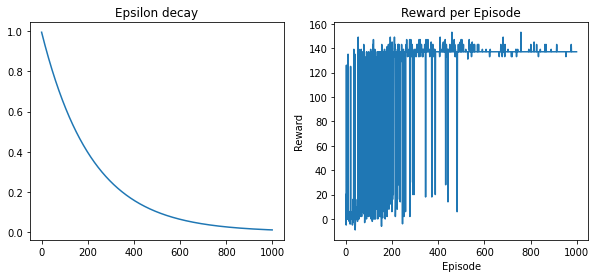

In [10]:
# visualization for training
_, _, testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals, _ = SARSA(
    env=GridEnvironment(), testing=False, episodes=1000, timesteps=10)
visualization(testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals)

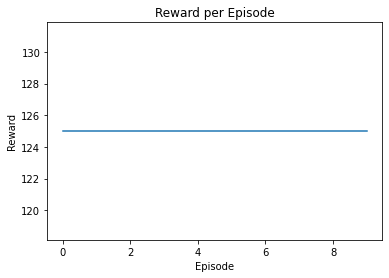

In [11]:
# visualization for testing
_, _, testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals, _ = SARSA(
    env=GridEnvironment(), testing=True, episodes=1000, timesteps=10)
visualization(testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals)

## Hyperparameter Tuning

### Hyperparameter 1 (Number of episodes)

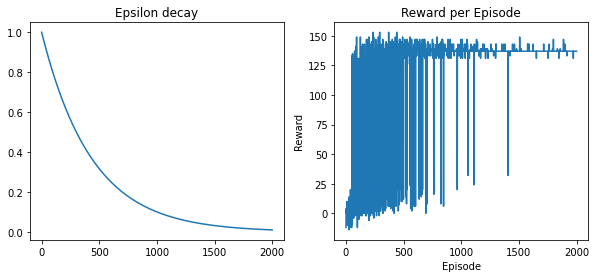

In [12]:
# Setting Number of episodes = 2000
_, _, testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals, _ = SARSA(
    env=GridEnvironment(), testing=False, episodes=2000, timesteps=10)
visualization(testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals)

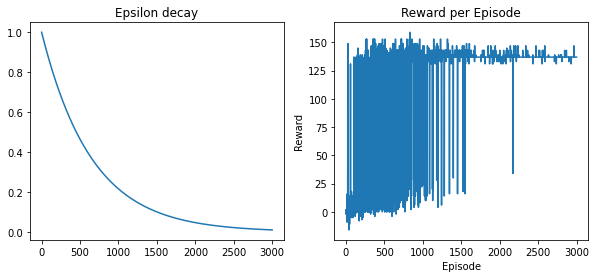

In [13]:
# Setting Number of episodes = 3000
_, _, testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals, _ = SARSA(
    env=GridEnvironment(), testing=False, episodes=3000, timesteps=10)
visualization(testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals)

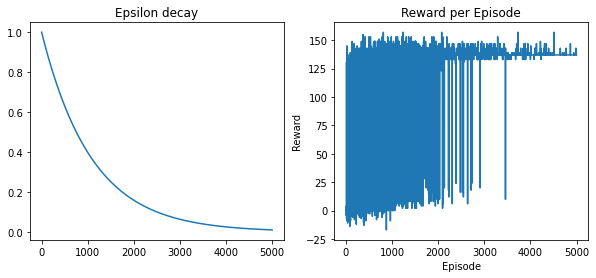

In [14]:
# Setting Number of episodes = 5000
_, _, testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals, _ = SARSA(
    env=GridEnvironment(), testing=False, episodes=5000, timesteps=10)
visualization(testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals)

### Hyperparameter 2 (Max timesteps)

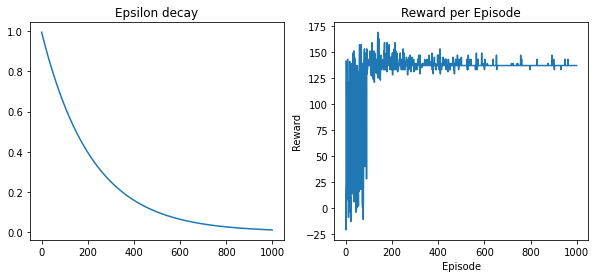

In [15]:
# Setting Number of timesteps = 20
_, _, testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals, _ = SARSA(
    env=GridEnvironment(), testing=False, episodes=1000, timesteps=20)
visualization(testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals)

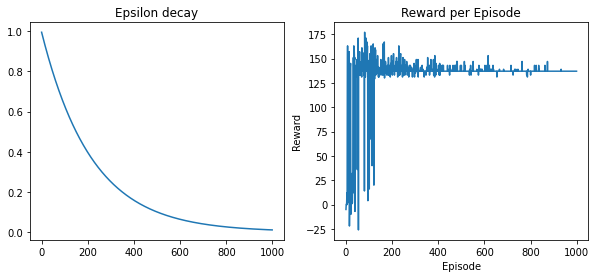

In [16]:
# Setting Number of timesteps = 30
_, _, testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals, _ = SARSA(
    env=GridEnvironment(), testing=False, episodes=1000, timesteps=30)
visualization(testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals)

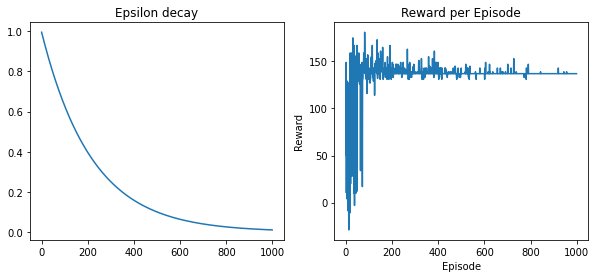

In [17]:
# Setting Number of timesteps = 40
_, _, testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals, _ = SARSA(
    env=GridEnvironment(), testing=False, episodes=1000, timesteps=40)
visualization(testingEpisodes, episodes, rewardVals, epsilonVals, testingRewardVals)